In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Bitter.csv")

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,4,5,6,8,9,179,180,182,260,261,263,264,266,269,277,278,296) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Functions implementations:

In [3]:

#Columns to be kept separate from the dataframe on which the processing is performed
colsToKeep = ['ID', 'Name', 'ACTIVITY']

#Half of the number of records in the dataframe
half_df = df.shape[0]/2

#Deleting the columns where more than 50 percent of the data is missing
def delete_missing_value_cols(df):
    df.dropna(axis = 1, how = 'any', thresh = half_df, subset = None, inplace = True)

#Filtering columns that contain identical values in more than half of the values
def delete_cols_that_val_repeats_more_than_50_percent(df):
    colsToRemove = []
    for col in df:
        if df[col].value_counts().max() > half_df:
            colsToRemove.append(col)
    df.drop(colsToRemove, axis=1, inplace = True)

#The function corrects to numeric format columns that were mistakenly classified as an object but contain numbers
def fix_wrongly_classified_object_cols(df):
    fixedList = []
    objectCols = np.where(df.dtypes == 'object')[0]
    for index in objectCols:
        fixedList = []
        if check_if_numeric_col(df[df.columns[index]], fixedList):
            df[df.columns[index]] = fixedList

#The function deletes columns classified as an object
def delete_object_cols(df):
    colsToRemove = []
    objectCols = np.where(df.dtypes == 'object')[0]
    for index in objectCols:
        colsToRemove.append(df.columns[index])
    df.drop(colsToRemove, axis=1, inplace = True)

#The function checks whether the column contains only numeric values and if so updates a list of corrected values to a numeric format
def check_if_numeric_col(col, fixedList):
    for val in col:
        try:
            fixedList.append(float(val))
        except ValueError:
            try:
                fixedList.append(float(val.replace(',','')))
            except ValueError:
                return False
    return True

#The function returns a table indicating the outliers
def detect_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outliers_df = (df < lower_range) != (df > upper_range)
    return outliers_df
        
#The function deletes the rows that contain an amount of outliers above the average in the other rows that contain outliers
def delete_rows_that_contains_outliers_above_the_average(df):
    outlierCounter = []
    outliersIndexes = []
    rowsToDrop = []
    outliers_df = detect_outliers(df)
    for index, row in outliers_df.iterrows():
        numOfOutliers = len(np.where(row == True)[0])
        if numOfOutliers != 0:
            outliersIndexes.append(index)
            outlierCounter.append(numOfOutliers)
    outliersAvg = sum(outlierCounter) / len(outlierCounter)
    for  i, index in enumerate(outliersIndexes):
        if outlierCounter[i] > outliersAvg:
            rowsToDrop.append(index)
    df.drop(rowsToDrop, axis=0, inplace=True)
    dfColsToKeep.drop(rowsToDrop, axis=0, inplace=True)
    
#The function checks for each pair of columns whether the correlation is higher than 0.8, if so it will delete one of the columns    
def delete_highly_correlated_variables(df):
    #Creating a correlation matrix
    corr_matrix = df.corr().abs()
    
    #Selecting the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    #Finding the variables between which the correlation is greater than 0.8 and deleting them
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    df.drop(to_drop, axis=1, inplace=True)


### Turning the target variable "Activity" into a binary variable and separating it from the rest of the data frame, as well as separating the variables "Name" and "ID"

In [4]:
dfColsToKeep = df[colsToKeep]
dfColsToKeep.ACTIVITY.replace(('Bitter', 'Non-Bitter'), (1, 0), inplace=True)
dfColsToKeep.ACTIVITY = dfColsToKeep.ACTIVITY.astype('category')
df.drop(colsToKeep, axis=1, inplace = True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Cleaning the raw data

In [5]:
df.drop_duplicates(inplace = True)
delete_missing_value_cols(df)
delete_cols_that_val_repeats_more_than_50_percent(df)
fix_wrongly_classified_object_cols(df)
delete_object_cols(df)
df.fillna(df.mean(),inplace=True)

### Removing rows that contains outliers above the avarage

In [6]:
delete_rows_that_contains_outliers_above_the_average(df)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Removing highly correlated variables

In [7]:
delete_highly_correlated_variables(df)

<ipython-input-3-c38ea345b60d>:82: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


### Boxplot visualization of the data

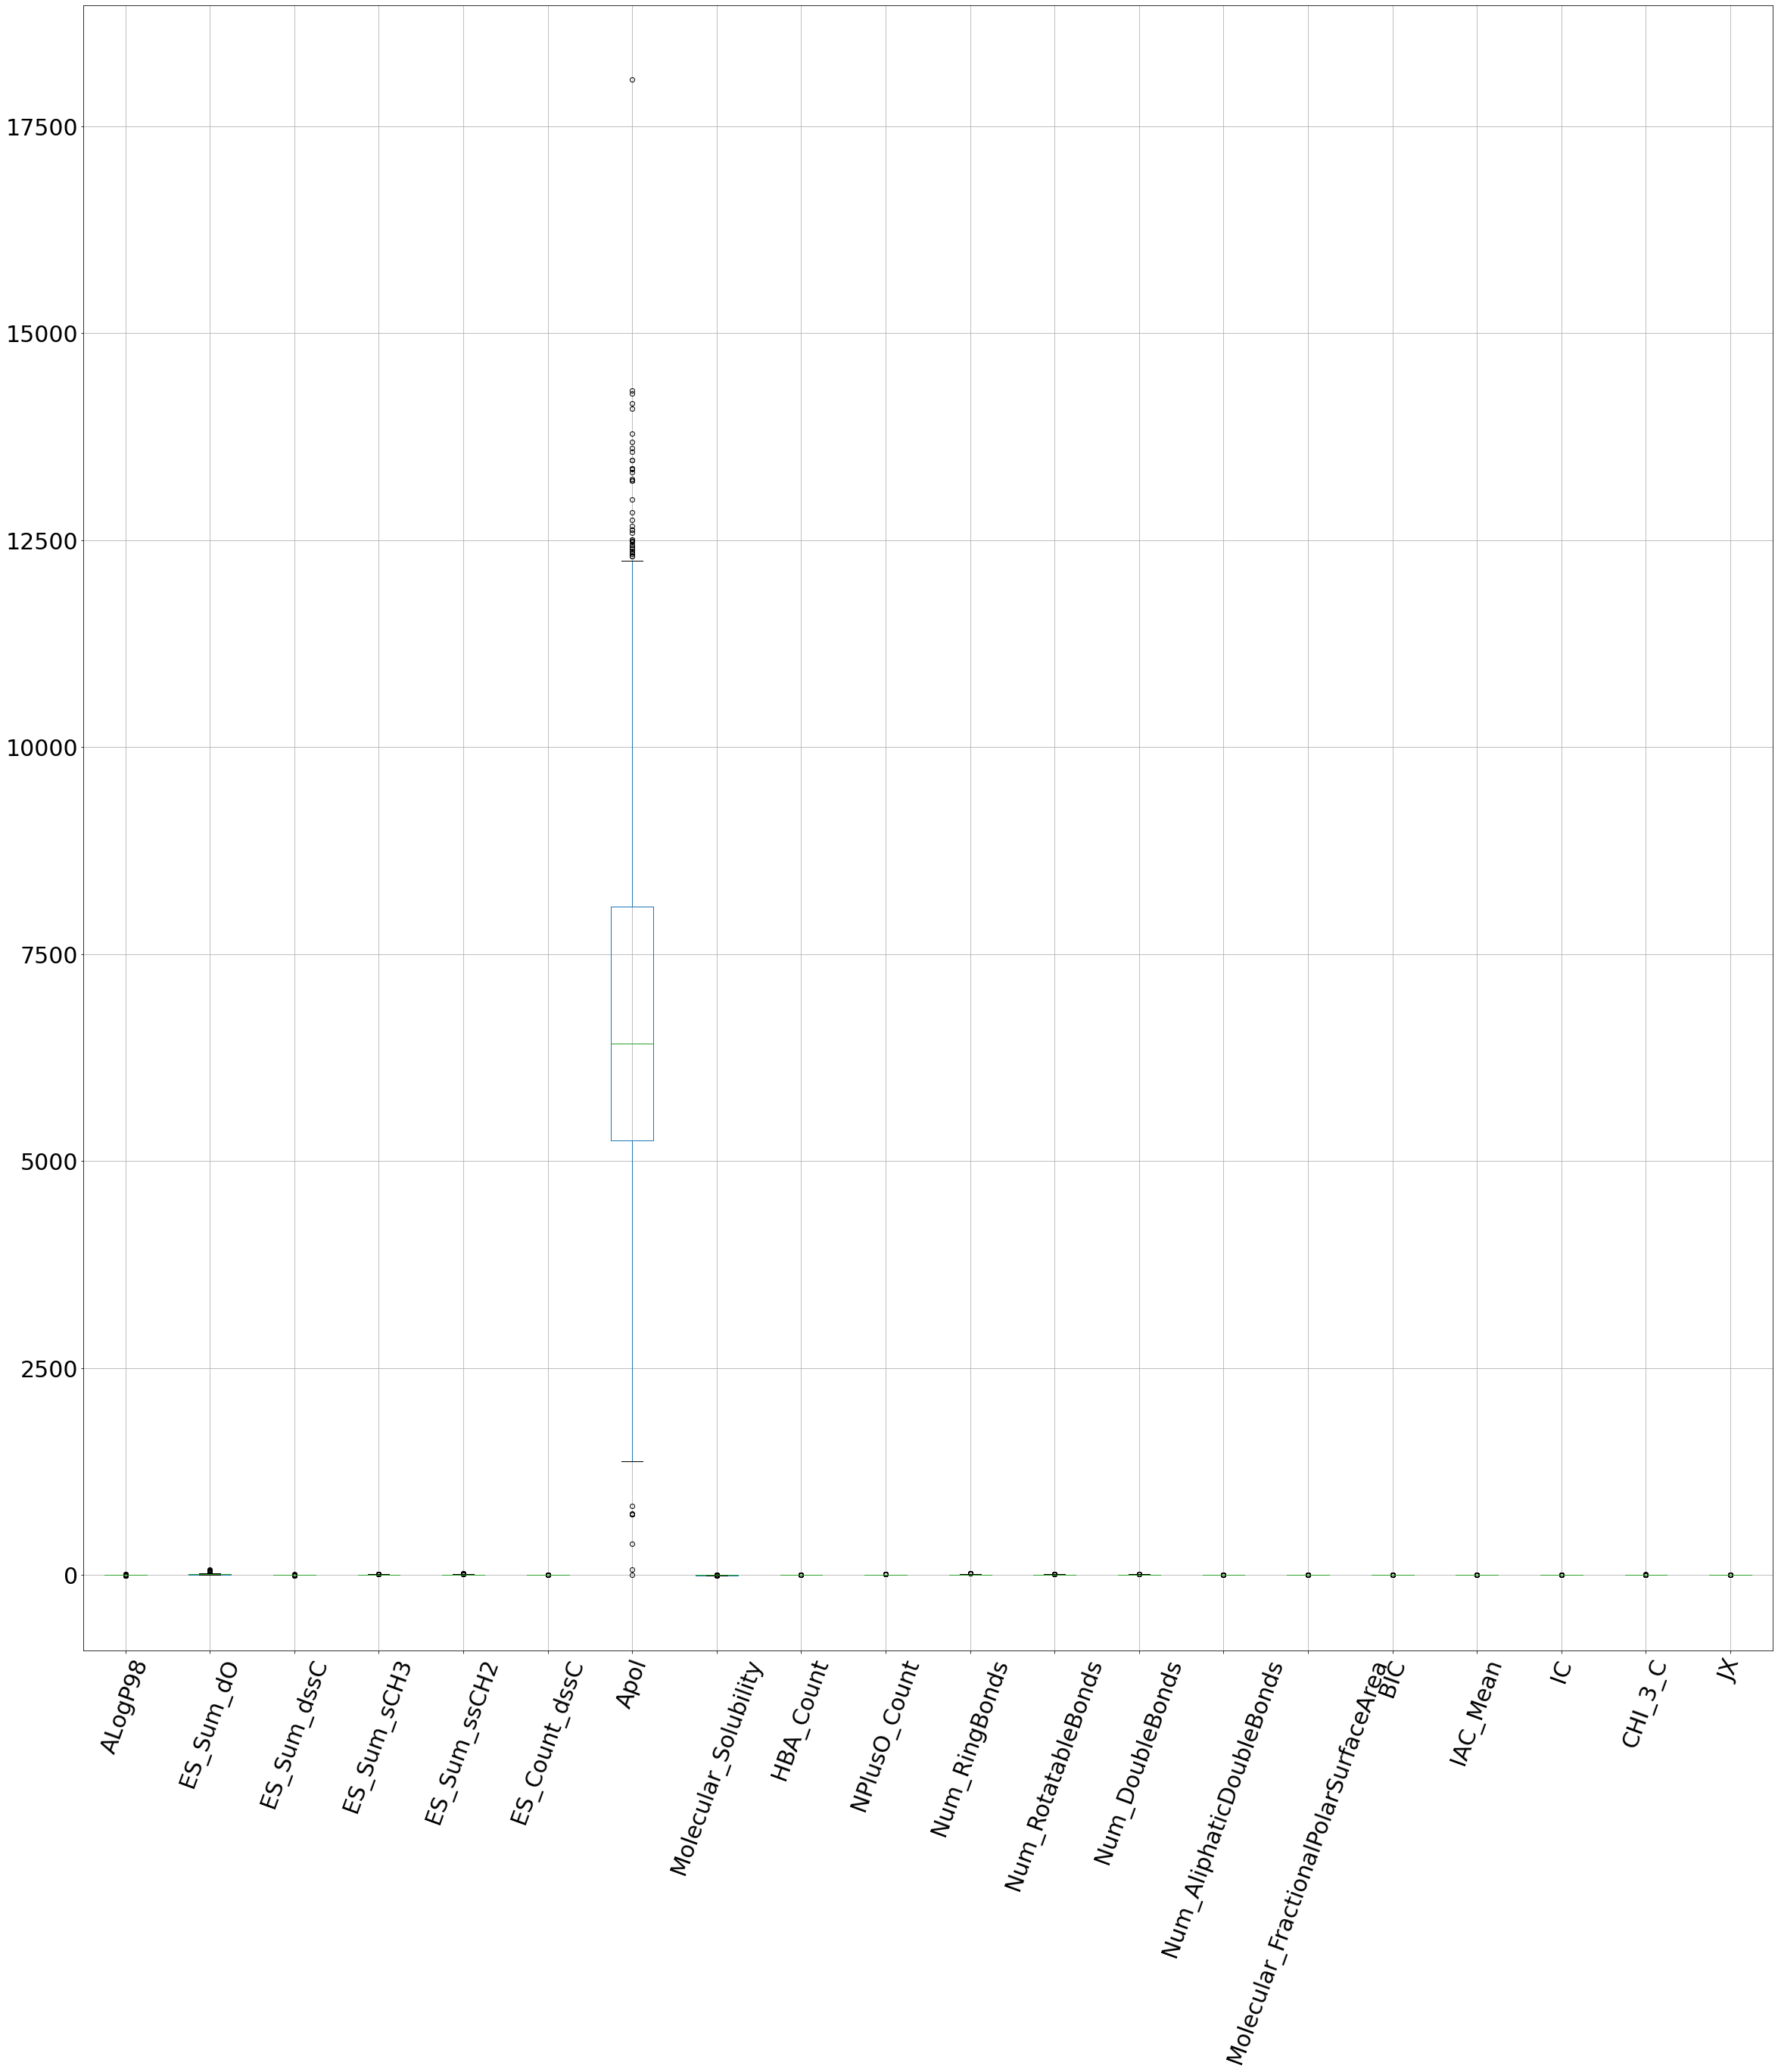

In [8]:
df.drop(['Index', 'PUBCHEM_COMPOUND_CID'], axis=1, inplace = True)
#Original data:
df.boxplot(figsize=(40,40),rot=70, fontsize=30);

### Boxplot visualization of the normalized data

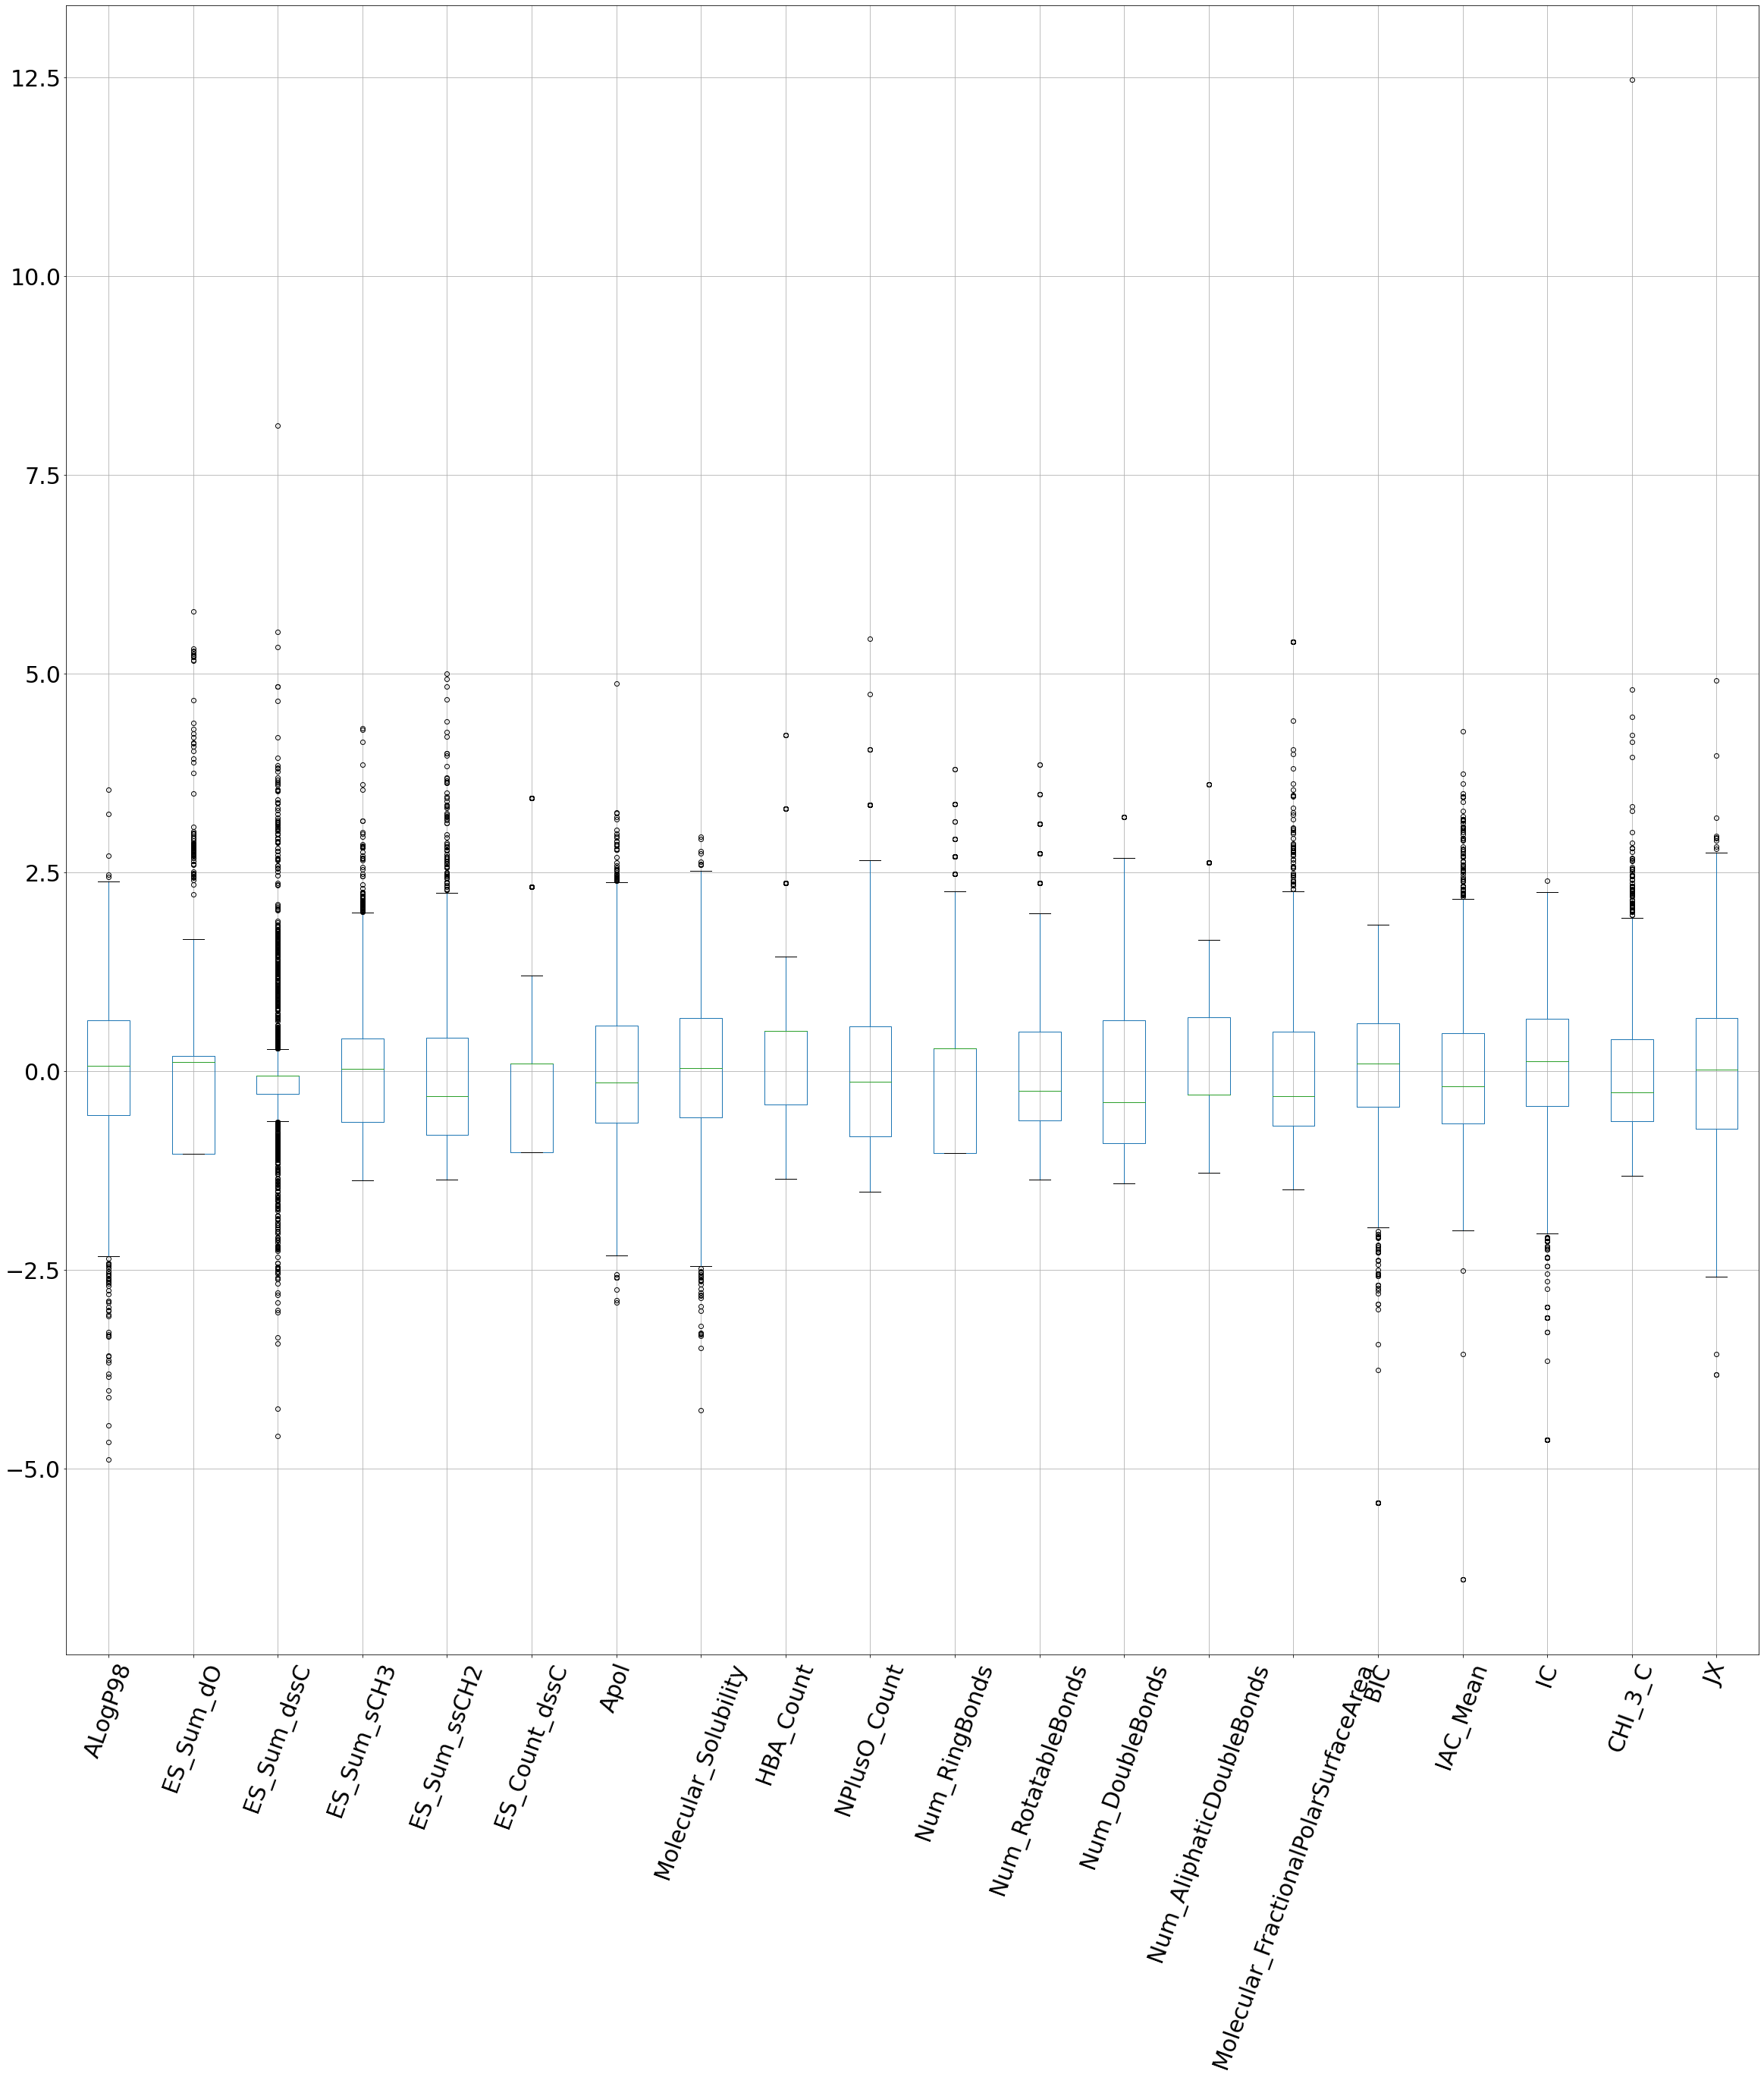

In [9]:
#Normalized data:
normalizedDf = (df - df.mean()) / df.std()
normalizedDf.boxplot(figsize=(40,40),rot=70, fontsize=30);

### Variables histograms (value counts)

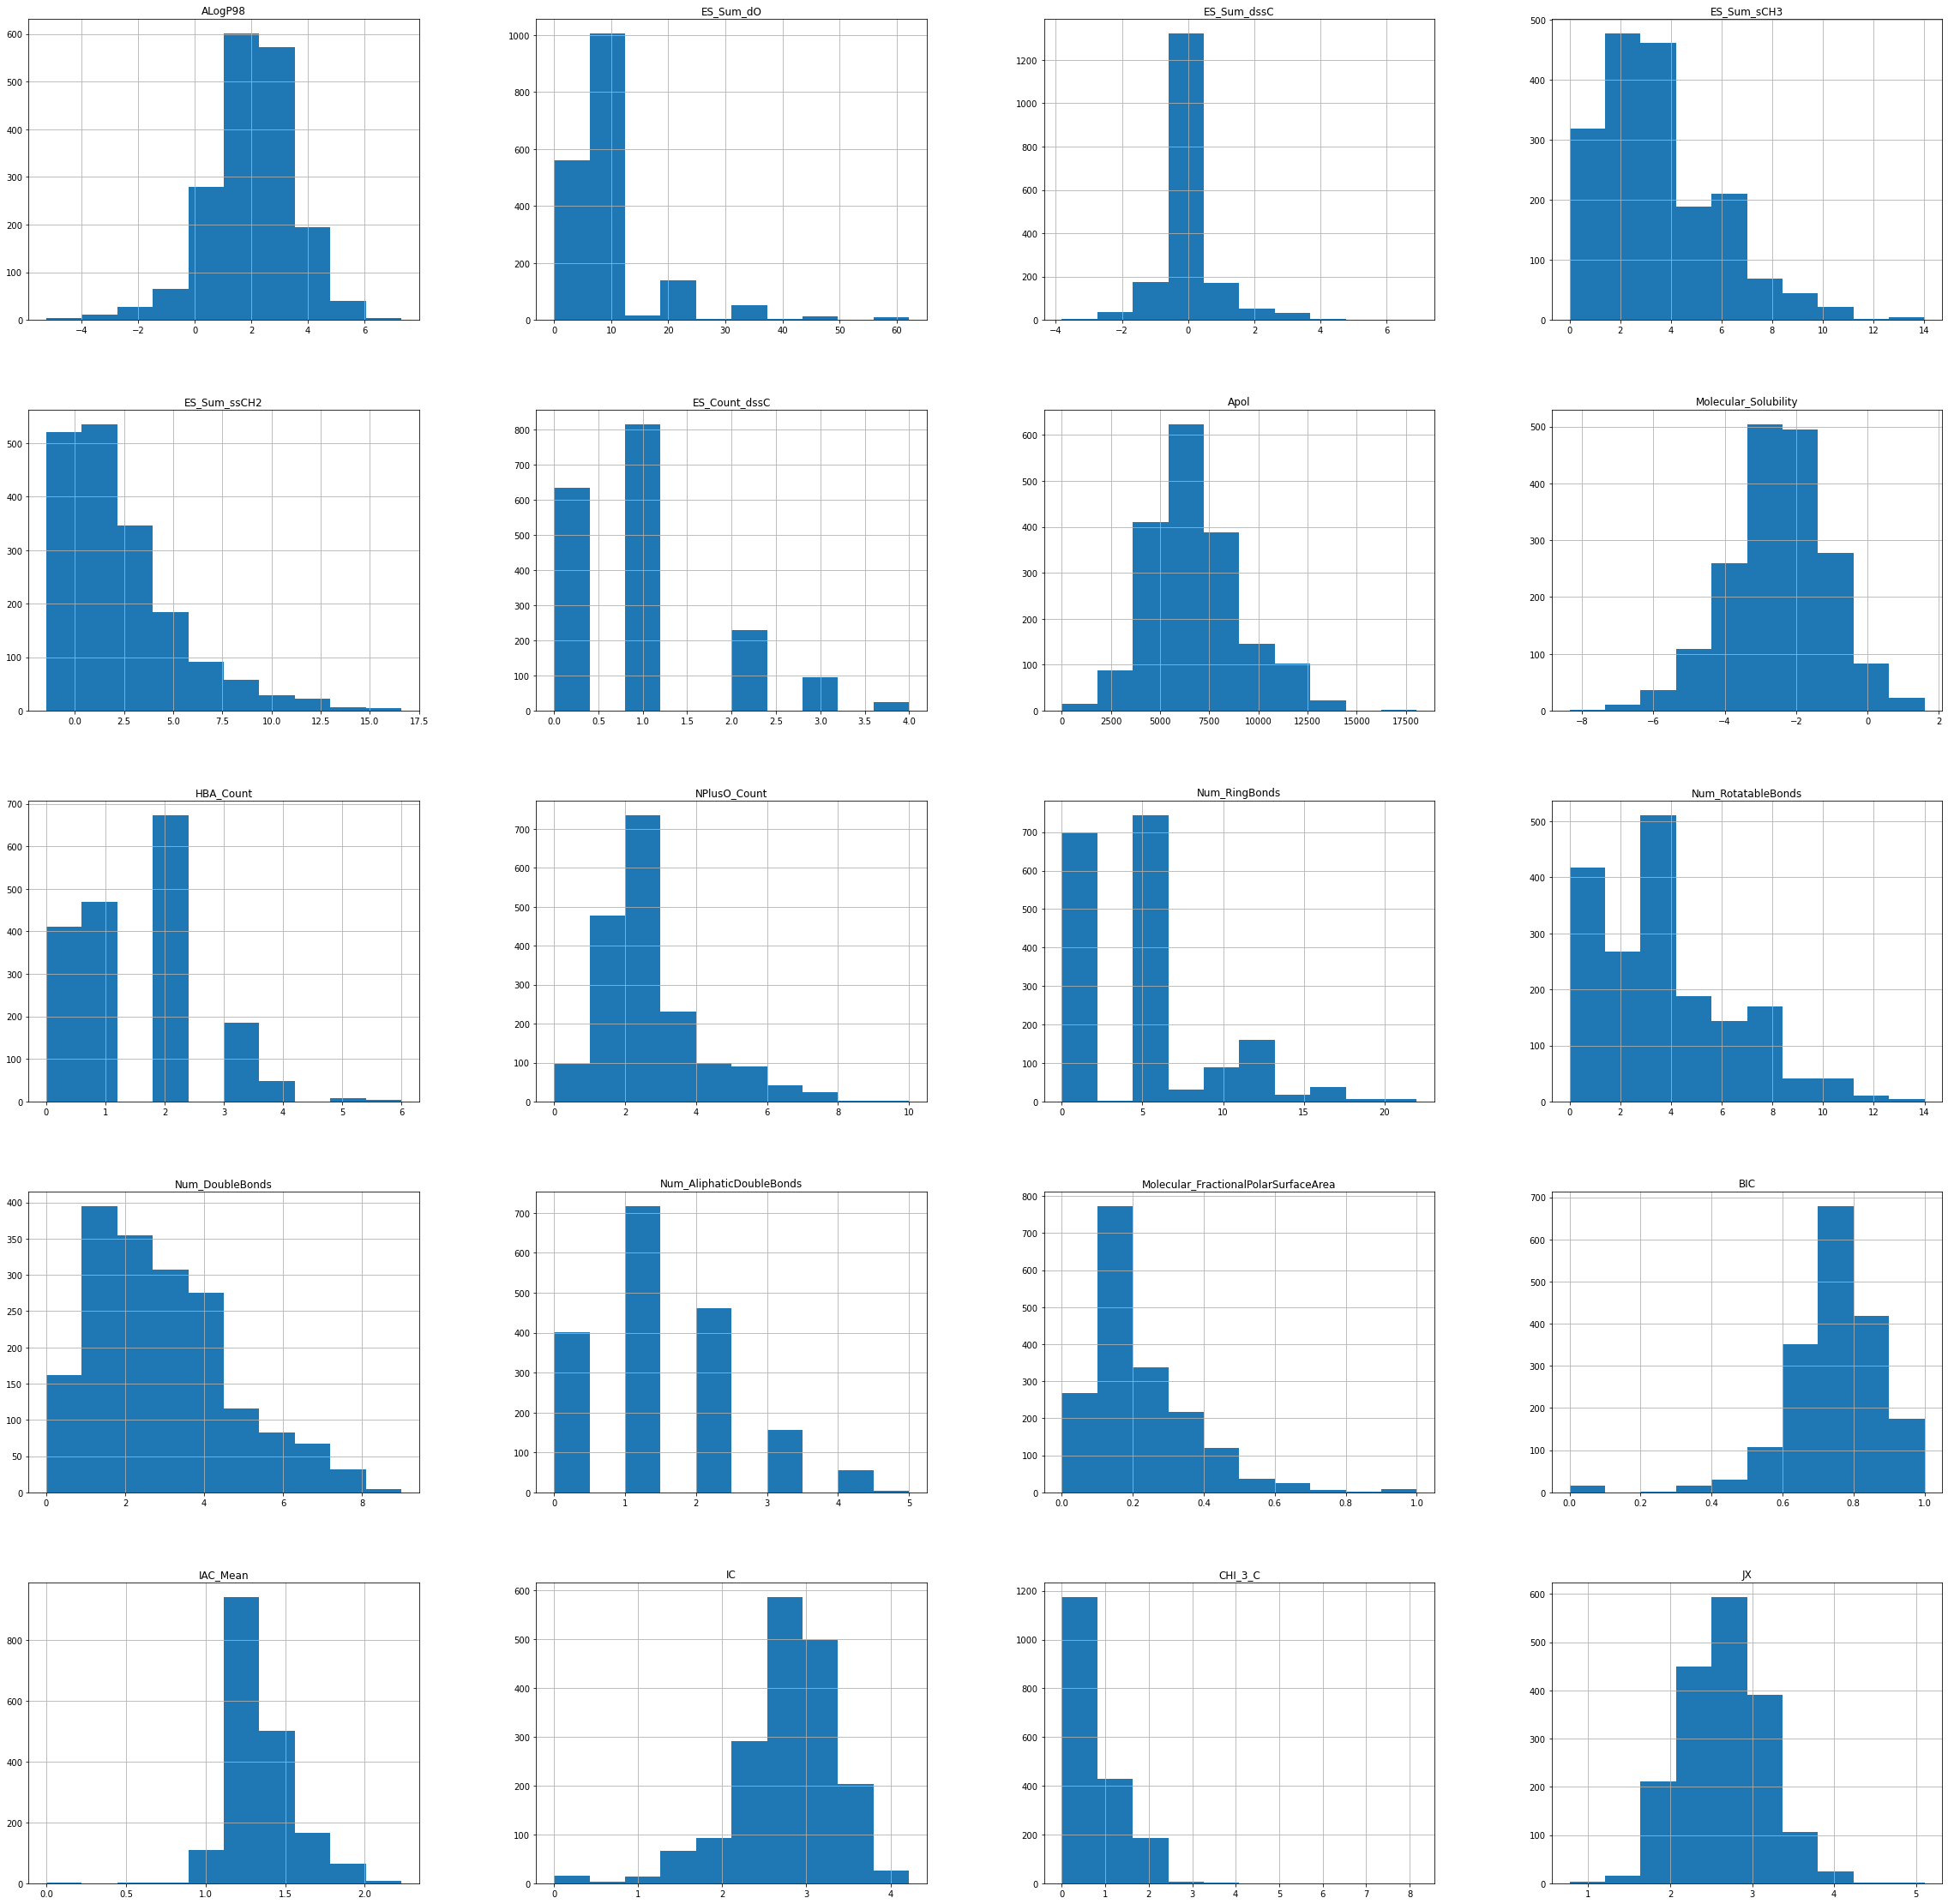

In [10]:
df.hist(figsize = (40,40));

### Creating statistics dataframe

In [11]:
df = dfColsToKeep.join(df)
dfForStatistics = df.copy()
dfForStatistics.ACTIVITY = dfForStatistics.ACTIVITY.astype('int64')
Min = dfForStatistics.min()
Max = dfForStatistics.max()
Range = []
for i in range(len(Min)):
    Range.append(f"{Min[i]}  -  {Max[i]}")
Mean = dfForStatistics.mean()
SD = dfForStatistics.std()
statisticsDf = pd.DataFrame({"Range" : Range, "Mean" : Mean, "SD" : SD, "Frequency (Binary)" : ''})
statisticsDf.at['ACTIVITY', 'Mean'] = np.nan
statisticsDf.at['ACTIVITY', 'SD'] = np.nan
numOfNonBitter, numOfBitter = dfColsToKeep.ACTIVITY.value_counts()
nonBitterPercentage, bitterPercentage = dfColsToKeep.ACTIVITY.value_counts() / sum([numOfNonBitter, numOfBitter])
statisticsDf.at['ACTIVITY', 'Frequency (Binary)'] = f"0: {numOfNonBitter} Non-bitter({nonBitterPercentage:.2%}), 1: {numOfBitter} Bitter({bitterPercentage:.2%})"

statisticsDf

,Range,Mean,SD,Frequency (Binary)
ACTIVITY,0.0 - 1.0,NaN,NaN,"0: 1437 Non-bitter(79.97%), 1: 360 Bitter(20.03%)"
ALogP98,-5.254 - 7.307,2.032078,1.491034,
ES_Sum_dO,0.0 - 62.168,9.483066,9.118120,
ES_Sum_dssC,-3.821 - 6.908,0.054920,0.844318,
ES_Sum_sCH3,0.0 - 14.009,3.392513,2.462785,
ES_Sum_ssCH2,-1.452 - 16.598,2.421467,2.836754,
ES_Count_dssC,0.0 - 4.0,0.920979,0.898148,
Apol,0.0 - 18058.8,6761.152329,2318.643719,
Molecular_Solubility,-8.351 - 1.597,-2.460833,1.379588,
HBA_Count,0.0 - 6.0,1.457986,1.074631,


### Exporting the processed dataframe and the processed normalized dataframe

In [12]:
df.to_csv('final_df.csv')
df.drop(colsToKeep, axis = 1, inplace = True)
normalizedDf = (df - df.mean()) / df.std()
df = dfColsToKeep.join(df)
normalizedDf = dfColsToKeep.join(normalizedDf)
normalizedDf.to_csv('final_df_normalized.csv')